# Homework 4: Build a CNN for Image Recognition

### Name: Tyler Bryk


## 1. Data Preparation

### 1.1. Load data

In [1]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

Using TensorFlow backend.


shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [3]:
# Convert Image Data to Float-32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Standardize Data with Z-scores
mean = numpy.mean(x_train, axis=(0,1,2,3))
std  = numpy.std(x_train, axis=(0,1,2,3))
x_train = (x_train - mean) / (std + 1e-7)
x_test  = (x_test - mean) / (std + 1e-7)

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [4]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(1e-4), input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation('softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

In [6]:
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=15, 
                         width_shift_range=0.1,  
                         height_shift_range=0.1,
                         shear_range=0.3,
                         zoom_range=0.1, 
                         horizontal_flip=True)
gen.fit(x_tr)
train_generator = gen.flow(x_tr, y_tr, batch_size=64)
test_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=64)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001, decay=1e-6),
              metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch=40000//64, epochs=40, validation_data=test_generator, validation_steps=10000//64)

Epoch 1/40
625/625 [==============================] - 43s 68ms/step - loss: 1.4372 - accuracy: 0.5164 - val_loss: 1.4614 - val_accuracy: 0.5772
Epoch 2/40
625/625 [==============================] - 41s 65ms/step - loss: 1.0944 - accuracy: 0.6488 - val_loss: 1.2678 - val_accuracy: 0.5674
Epoch 3/40
625/625 [==============================] - 41s 65ms/step - loss: 0.9581 - accuracy: 0.6962 - val_loss: 0.9060 - val_accuracy: 0.6994
Epoch 4/40
625/625 [==============================] - 40s 65ms/step - loss: 0.8839 - accuracy: 0.7228 - val_loss: 1.0449 - val_accuracy: 0.6823
Epoch 5/40
625/625 [==============================] - 41s 65ms/step - loss: 0.8266 - accuracy: 0.7462 - val_loss: 0.9078 - val_accuracy: 0.7466
Epoch 6/40
625/625 [==============================] - 41s 65ms/step - loss: 0.7884 - accuracy: 0.7578 - val_loss: 0.9497 - val_accuracy: 0.7676
Epoch 7/40
625/625 [==============================] - 41s 65ms/step - loss: 0.7523 - accuracy: 0.7732 - val_loss: 0.7326 - val_accuracy:

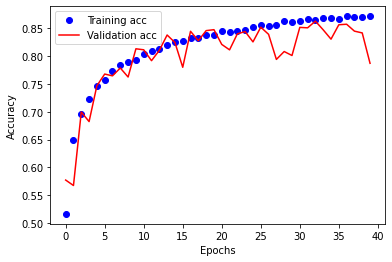

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

In [8]:
gen = ImageDataGenerator(rotation_range=15, 
                         width_shift_range=0.1,  
                         height_shift_range=0.1,
                         shear_range=0.3,
                         zoom_range=0.1, 
                         horizontal_flip=True)
gen.fit(x_train)
train_generator = gen.flow(x_train, y_train_vec, batch_size=64)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001, decay=1e-6),
              metrics=['accuracy'])

history = model.fit_generator(train_generator, steps_per_epoch=50000//64, epochs=40)

Epoch 1/40
781/781 [==============================] - 50s 64ms/step - loss: 0.5427 - accuracy: 0.8636
Epoch 2/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5398 - accuracy: 0.8660
Epoch 3/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5307 - accuracy: 0.8705
Epoch 4/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5304 - accuracy: 0.8688
Epoch 5/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5257 - accuracy: 0.8711
Epoch 6/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5237 - accuracy: 0.8723
Epoch 7/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5182 - accuracy: 0.8744
Epoch 8/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5202 - accuracy: 0.8734
Epoch 9/40
781/781 [==============================] - 48s 62ms/step - loss: 0.5148 - accuracy: 0.8768
Epoch 10/40
781/781 [==============================] - 48s 62ms/step - loss: 0.511

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [9]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 4s 363us/step
loss = 0.5003511307239532
accuracy = 0.8827000260353088
